In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

import time
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from tqdm import tqdm


In [55]:
# Specify your dataset directory containing train, val, test folders
dataset_dir = r"C:\Amrita\7TH SEM\PROJECT PHASE - 1\1.2\Nor Abnor"  # Change this to your dataset path

train_dir = os.path.join(dataset_dir, r"C:\Amrita\7TH SEM\PROJECT PHASE - 1\1.2\Nor Abnor\Train")
val_dir = os.path.join(dataset_dir, r"C:\Amrita\7TH SEM\PROJECT PHASE - 1\1.2\Nor Abnor\Val")
test_dir = os.path.join(dataset_dir, r"C:\Amrita\7TH SEM\PROJECT PHASE - 1\1.2\Nor Abnor\Test")


In [56]:
def count_images_in_classes(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

print("Train Dataset:", count_images_in_classes(train_dir))
print("Validation Dataset:", count_images_in_classes(val_dir))
print("Test Dataset:", count_images_in_classes(test_dir))


Train Dataset: {'1': 1056, '2': 1516, '3': 757, '4': 173}
Validation Dataset: {'1': 153, '2': 212, '3': 106, '4': 27}
Test Dataset: {'1': 296, '2': 447, '3': 223, '4': 51}


In [57]:
# Define image transformations
transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Randomly resize and crop
    transforms.RandomHorizontalFlip(),  # Flip the image horizontally with 50% probability
    transforms.RandomRotation(10),  # Rotate images by up to 10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Adjust brightness & contrast
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# Create Data Loaders
batch_size =32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Get class names
class_names = train_dataset.classes
print("Classes:", class_names)


Classes: ['1', '2', '3', '4']


In [58]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load ConvNeXt Model
model = models.convnext_tiny(pretrained=True)  # Use 'convnext_small' or 'convnext_base' for larger models

# Modify the final classification layer
num_classes = len(class_names)
model.classifier[2] = nn.Linear(model.classifier[2].in_features, num_classes)

model = model.to(device)


C:\Users\shaah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\shaah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [59]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


In [60]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=10):
    start_time = time.time()
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(epochs):
        epoch_start = time.time()
        
        # Training phase
        model.train()
        train_loss, train_correct = 0, 0
        total_samples = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

        train_acc = train_correct / total_samples
        history['train_loss'].append(train_loss / total_samples)
        history['train_acc'].append(train_acc)

        # Validation phase
        model.eval()
        val_loss, val_correct = 0, 0
        total_samples = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                total_samples += labels.size(0)

        val_acc = val_correct / total_samples
        history['val_loss'].append(val_loss / total_samples)
        history['val_acc'].append(val_acc)

        scheduler.step()

        epoch_time = time.time() - epoch_start
        remaining_time = (epochs - (epoch + 1)) * epoch_time
        print(f"Epoch {epoch+1}/{epochs} - Time Taken: {epoch_time:.2f}s - Remaining: {remaining_time/60:.2f} min")

    total_time = time.time() - start_time
    print(f"Total Training Time: {total_time/60:.2f} minutes")
    return history


In [61]:
epochs = 10
history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs)


Epoch 1/10 - Training: 100%|██████████| 110/110 [08:24<00:00,  4.59s/it]


Epoch 1/10 - Time Taken: 528.77s - Remaining: 79.31 min


Epoch 2/10 - Training: 100%|██████████| 110/110 [08:35<00:00,  4.69s/it]


Epoch 2/10 - Time Taken: 538.85s - Remaining: 71.85 min


Epoch 3/10 - Training: 100%|██████████| 110/110 [08:24<00:00,  4.58s/it]


Epoch 3/10 - Time Taken: 527.85s - Remaining: 61.58 min


Epoch 4/10 - Training: 100%|██████████| 110/110 [08:51<00:00,  4.83s/it]


Epoch 4/10 - Time Taken: 557.16s - Remaining: 55.72 min


Epoch 5/10 - Training: 100%|██████████| 110/110 [09:02<00:00,  4.93s/it]


Epoch 5/10 - Time Taken: 568.12s - Remaining: 47.34 min


Epoch 6/10 - Training: 100%|██████████| 110/110 [09:02<00:00,  4.93s/it]


Epoch 6/10 - Time Taken: 568.39s - Remaining: 37.89 min


Epoch 7/10 - Training: 100%|██████████| 110/110 [09:12<00:00,  5.02s/it]


Epoch 7/10 - Time Taken: 579.67s - Remaining: 28.98 min


Epoch 8/10 - Training: 100%|██████████| 110/110 [09:20<00:00,  5.10s/it]


Epoch 8/10 - Time Taken: 586.61s - Remaining: 19.55 min


Epoch 9/10 - Training: 100%|██████████| 110/110 [08:30<00:00,  4.64s/it]


Epoch 9/10 - Time Taken: 531.59s - Remaining: 8.86 min


Epoch 10/10 - Training: 100%|██████████| 110/110 [07:34<00:00,  4.13s/it]


Epoch 10/10 - Time Taken: 475.70s - Remaining: 0.00 min
Total Training Time: 91.05 minutes


In [62]:
save_path = r"C:\Amrita\7TH SEM\PROJECT PHASE - 1\1.2\Models\ConvNeXt_Model_Aug.pth"
torch.save(model.state_dict(), save_path)
print(f"Model saved at {save_path}")


Model saved at C:\Amrita\7TH SEM\PROJECT PHASE - 1\1.2\Models\ConvNeXt_Model_Aug.pth


Classification Report:
               precision    recall  f1-score   support

           1       0.69      0.67      0.68       296
           2       0.71      0.76      0.74       447
           3       0.85      0.76      0.80       223
           4       0.87      0.88      0.87        51

    accuracy                           0.74      1017
   macro avg       0.78      0.77      0.77      1017
weighted avg       0.74      0.74      0.74      1017



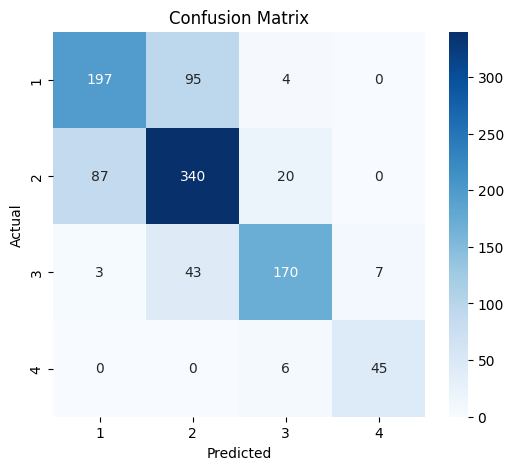

In [63]:
# Load model for inference
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Compute metrics
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names, digits=2))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
